<a href="https://colab.research.google.com/github/ChanglinWu/DL/blob/main/Transformer_Stock_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Stock Price Prediction

This example showcases the use of  Transformer for stock price prediction based on the previous 7 closing prices of a stock. We employ the Yahoo Finance API to download the required stock price data.

References:

- https://www.youtube.com/watch?v=q_HS4s1L8UI

- https://www.youtube.com/watch?v=lhDnIYauNgA

- https://www.youtube.com/watch?v=m3UvQxSgEtU (Use News to predict)

In [ ]:
!pip install yfinance -qqq
!pip install pandas_ta -qqq
!pip install plotly -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler

import sys
import yfinance as yf
import plotly
import plotly.graph_objects as go

In [ ]:
# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 10, 12)
PyTorch version: 2.1.0+cu121
Device: cpu


In [ ]:
# Define the ticker symobol and period for which we want to fetch the stock prices

ticker = 'BABA' # Ali BABA
# ticker = 'AMZN' # Amazon
# ticker = 'APPL' # Apple

start_date = '2012-03-11'
end_date = '2024-02-20'

# Download historical stock data for the ticker 'AMZN' from March 11, 2012, to February 10, 2024
data = yf.download(tickers=ticker, start=start_date, end=end_date)

data.tail(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-05,72.169998,75.150002,71.860001,74.629997,74.629997,27721000
2024-02-06,77.044998,78.339996,75.730003,78.230003,78.230003,39069100
2024-02-07,74.555000,76.169998,73.150002,73.639999,73.639999,53766300
2024-02-08,71.885002,73.199997,70.650002,70.779999,70.779999,33070600
2024-02-09,70.800003,72.084999,70.000000,72.019997,72.019997,18998400
2024-02-12,72.309998,74.129997,72.309998,73.139999,73.139999,18151100
2024-02-13,71.959999,73.029999,71.419998,71.599998,71.599998,13560600
2024-02-14,72.309998,73.410004,72.230003,73.389999,73.389999,12817500
2024-02-15,73.220001,74.139999,73.084999,73.820000,73.820000,12078100


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2369 entries, 2014-09-19 to 2024-02-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2369 non-null   float64
 1   High       2369 non-null   float64
 2   Low        2369 non-null   float64
 3   Close      2369 non-null   float64
 4   Adj Close  2369 non-null   float64
 5   Volume     2369 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 129.6 KB


In [ ]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-19,92.699997,99.699997,89.949997,93.889999,92.644608,271879400
2014-09-22,92.699997,92.949997,89.500000,89.889999,88.697670,66657800
2014-09-23,88.940002,90.480003,86.620003,87.169998,86.013741,39009800
2014-09-24,88.470001,90.570000,87.220001,90.570000,89.368645,32088000
2014-09-25,91.089996,91.500000,88.500000,88.919998,87.740532,28598000


In [ ]:
# Reset the index of the DataFrame
data = data.reset_index()
# data = data.reset_index(drop=True, inplace=True)

# Select only the 'Date' and 'Close' columns from the DataFrame
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-19,92.699997,99.699997,89.949997,93.889999,92.644608,271879400
1,2014-09-22,92.699997,92.949997,89.500000,89.889999,88.697670,66657800
2,2014-09-23,88.940002,90.480003,86.620003,87.169998,86.013741,39009800
3,2014-09-24,88.470001,90.570000,87.220001,90.570000,89.368645,32088000
4,2014-09-25,91.089996,91.500000,88.500000,88.919998,87.740532,28598000
...,...,...,...,...,...,...,...
2364,2024-02-12,72.309998,74.129997,72.309998,73.139999,73.139999,18151100
2365,2024-02-13,71.959999,73.029999,71.419998,71.599998,71.599998,13560600
2366,2024-02-14,72.309998,73.410004,72.230003,73.389999,73.389999,12817500
2367,2024-02-15,73.220001,74.139999,73.084999,73.820000,73.820000,12078100


# Candle Stick Chart of the Stock

In [ ]:
# Create the candlestick chart
fig = go.Figure(
    data=[go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'])])

# Customize the Chart Layout
fig.update_layout(
    title=F'Stock Price Chart {ticker}',
    yaxis_title='Price ($)',
    xaxis_rangeslider_visible=False)

# Display the chart
fig.show()


In [ ]:
# Reset the index of the DataFrame
data = data.reset_index()

# Select only the 'Date' and 'Close' columns from the DataFrame
data = data[['Date', 'Close']]


data

,Date,Close
0,2014-09-19,93.889999
1,2014-09-22,89.889999
2,2014-09-23,87.169998
3,2014-09-24,90.570000
4,2014-09-25,88.919998
...,...,...
2364,2024-02-12,73.139999
2365,2024-02-13,71.599998
2366,2024-02-14,73.389999
2367,2024-02-15,73.820000


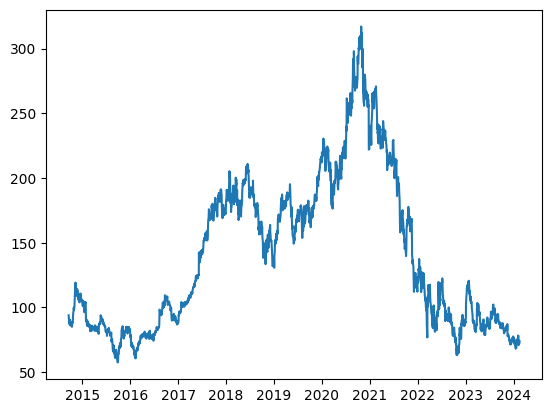

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

# Create a New DataFrame as a Training Dataset

In this new dataframe the current close price and previous 7 close prices are arranged as a record (a row).

The previous 7 close prices Close(t-1) to Close (t-7) are used to predict the current close price.

In [ ]:
from copy import deepcopy as dc

# Define a function named 'prepare_dataframe_for_lstm' that takes a DataFrame 'df' and the number of time steps 'n_steps' as parameters
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    # Set the 'Date' column as the index of the DataFrame
    df.set_index('Date', inplace=True)

    # Generate lagged columns for the 'Close' price,
    # shifting the values by 'i' time steps
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    # Drop rows with missing values (NaN) resulting from the shift operation
    df.dropna(inplace=True)

    return df

# Define the number of previous time steps to consider for the LSTM model
lookback = 10

# Call the 'prepare_dataframe_for_lstm' function to create a new DataFrame
# with lagged columns
shifted_df = prepare_dataframe_for_lstm(data, lookback)

# Display the resulting DataFrame with lagged columns
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2014-10-03,88.099998,87.059998,86.099998,88.849998,88.750000,90.459999,88.919998,90.570000,87.169998,89.889999,93.889999
2014-10-06,88.309998,88.099998,87.059998,86.099998,88.849998,88.750000,90.459999,88.919998,90.570000,87.169998,89.889999
2014-10-07,87.669998,88.309998,88.099998,87.059998,86.099998,88.849998,88.750000,90.459999,88.919998,90.570000,87.169998
2014-10-08,88.300003,87.669998,88.309998,88.099998,87.059998,86.099998,88.849998,88.750000,90.459999,88.919998,90.570000
2014-10-09,88.790001,88.300003,87.669998,88.309998,88.099998,87.059998,86.099998,88.849998,88.750000,90.459999,88.919998
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12,73.139999,72.019997,70.779999,73.639999,78.230003,74.629997,71.849998,72.459999,72.169998,72.320000,73.580002
2024-02-13,71.599998,73.139999,72.019997,70.779999,73.639999,78.230003,74.629997,71.849998,72.459999,72.169998,72.320000
2024-02-14,73.389999,71.599998,73.139999,72.019997,70.779999,73.639999,78.230003,74.629997,71.849998,72.459999,72.169998


In [ ]:
# Convert the Shifted Dataframe to Numpy
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[88.09999847, 87.05999756, 86.09999847, ..., 87.16999817,
        89.88999939, 93.88999939],
       [88.30999756, 88.09999847, 87.05999756, ..., 90.56999969,
        87.16999817, 89.88999939],
       [87.66999817, 88.30999756, 88.09999847, ..., 88.91999817,
        90.56999969, 87.16999817],
       ...,
       [73.38999939, 71.59999847, 73.13999939, ..., 71.84999847,
        72.45999908, 72.16999817],
       [73.81999969, 73.38999939, 71.59999847, ..., 74.62999725,
        71.84999847, 72.45999908],
       [73.91000366, 73.81999969, 73.38999939, ..., 78.23000336,
        74.62999725, 71.84999847]])

In [ ]:
# Show the dimension of the shifted dataframe
shifted_df_as_np.shape

(2359, 11)

In [ ]:
# Data Standardization
# Scale the data in the range (-1, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.76354189, -0.77154959, -0.77894131, ..., -0.77070262,
        -0.7497594 , -0.71896056],
       [-0.76192496, -0.76354189, -0.77154959, ..., -0.74452359,
        -0.77070262, -0.7497594 ],
       [-0.76685277, -0.76192496, -0.76354189, ..., -0.75722813,
        -0.74452359, -0.77070262],
       ...,
       [-0.87680463, -0.89058712, -0.87872955, ..., -0.88866219,
        -0.88396536, -0.88619828],
       [-0.87349375, -0.87680463, -0.89058712, ..., -0.867257  ,
        -0.88866219, -0.88396536],
       [-0.87280074, -0.87349375, -0.87680463, ..., -0.839538  ,
        -0.867257  , -0.88866219]])

In [ ]:
# Print the shape of the training data and label
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((2359, 10), (2359,))

In [ ]:
# The data is needed to flip in order to predict the current price
# It is becasue we want to input the close price in the order of
# close(t-7), close(t-6),..., close(t-1)
X = dc(np.flip(X, axis=1))
X

array([[-0.71896056, -0.7497594 , -0.77070262, ..., -0.75776711,
        -0.77894131, -0.77154959],
       [-0.7497594 , -0.77070262, -0.74452359, ..., -0.77894131,
        -0.77154959, -0.76354189],
       [-0.77070262, -0.74452359, -0.75722813, ..., -0.77154959,
        -0.76354189, -0.76192496],
       ...,
       [-0.88619828, -0.88396536, -0.88866219, ..., -0.88735325,
        -0.87872955, -0.89058712],
       [-0.88396536, -0.88866219, -0.867257  , ..., -0.87872955,
        -0.89058712, -0.87680463],
       [-0.88866219, -0.867257  , -0.839538  , ..., -0.89058712,
        -0.87680463, -0.87349375]])

In [ ]:
# Split the data into training set and test set

split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

print(F'split_index = {split_index}')
print(F'X_train.shape = {X_train.shape}')
print(F'X_test.shape = {X_test.shape}')
print(F'y_train.shape = {y_train.shape}')
print(F'y_test.shape = {y_test.shape}')

split_index = 2241
X_train.shape = (2241, 10)
X_test.shape = (118, 10)
y_train.shape = (2241,)
y_test.shape = (118,)


In [ ]:
# Add an extra dimension to fit the Pytorch LSTM training

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print(F'X_train.shape = {X_train.shape}')
print(F'X_test.shape = {X_test.shape}')
print(F'y_train.shape = {y_train.shape}')
print(F'y_test.shape = {y_test.shape}')

X_train.shape = (2241, 10, 1)
X_test.shape = (118, 10, 1)
y_train.shape = (2241, 1)
y_test.shape = (118, 1)


In [ ]:
# Convert the Numpy data to Pytorch Tensor

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(F'X_train.shape = {X_train.shape}')
print(F'X_test.shape = {X_test.shape}')
print(F'y_train.shape = {y_train.shape}')
print(F'y_test.shape = {y_test.shape}')


X_train.shape = torch.Size([2241, 10, 1])
X_test.shape = torch.Size([118, 10, 1])
y_train.shape = torch.Size([2241, 1])
y_test.shape = torch.Size([118, 1])


# Create the Dataset and Data Loader

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
train_dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


# Define the Transformer Model

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Constructing the Transformer Model
The following code constructs the actual transformer-based model for time series prediction. The model is constructed to accept the following parameters.

input_dim: The dimension of the input data, in this case we use only one input, the number of sunspots.
d_model: The number of features in the transformer model's internal representations (also the size of embeddings). This controls how much a model can remember and process.
nhead: The number of attention heads in the multi-head self-attention mechanism.
num_layers: The number of transformer encoder layers. dropout: The dropout probability.

In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



In [ ]:
model

TransformerModel(
  (encoder): Linear(in_features=1, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_stacked_layers):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_stacked_layers = num_stacked_layers

#         self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
#                             batch_first=True)

#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         batch_size = x.size(0)
#         h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

# model = LSTM(1, 4, 1)
# model.to(device)
# model

# Traning the Model

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1} ', end=" ")
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches), end=" ")
            running_loss = 0.0
#     print()

In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1  Batch 100, Loss: 0.204 Val Loss: 0.001
***************************************************

Epoch: 2  Batch 100, Loss: 0.016 Val Loss: 0.001
***************************************************

Epoch: 3  Batch 100, Loss: 0.012 Val Loss: 0.009
***************************************************

Epoch: 4  Batch 100, Loss: 0.010 Val Loss: 0.005
***************************************************

Epoch: 5  Batch 100, Loss: 0.010 Val Loss: 0.005
***************************************************

Epoch: 6  Batch 100, Loss: 0.007 Val Loss: 0.001
***************************************************

Epoch: 7  Batch 100, Loss: 0.006 Val Loss: 0.001
***************************************************

Epoch: 8  Batch 100, Loss: 0.007 Val Loss: 0.002
***************************************************

Epoch: 9  Batch 100, Loss: 0.007 Val Loss: 0.002
***************************************************

Epoch: 10  Batch 100, Loss: 0.006 Val Loss: 0.000
********************************

# Evaluate the Transformer Prediction

In [ ]:
# Make prediction using the trained LSTM model

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

# plt.plot(y_train, label='Actual Close')
# plt.plot(predicted, label='Predicted Close')
# plt.xlabel('Day')
# plt.ylabel('Close')
# plt.legend()
# plt.show()

In [ ]:
# Rescale the predicted close prices

train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([83.48150373, 84.25376122, 84.25267746, ..., 94.36198167,
       92.67920968, 92.5056685 ])

In [ ]:
# Rescale the label close prices

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([88.09999988, 88.30999416, 87.67000202, ..., 89.81999908,
       92.23999984, 94.0300023 ])

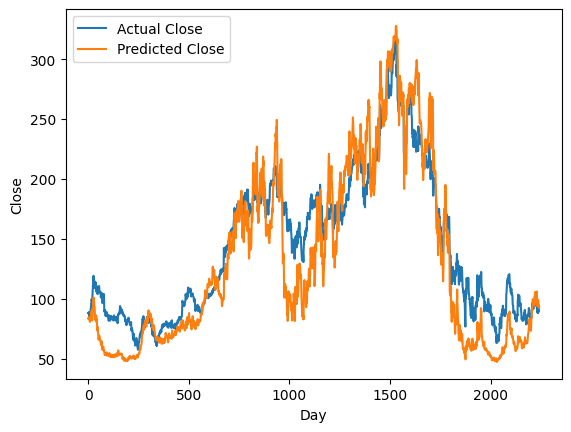

In [ ]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([86.8449576 , 86.60746675, 86.39120988, 88.51426772, 87.95790327,
       87.73676947, 84.30050231, 84.62720222, 83.34980348, 82.47616784,
       81.49095121, 81.38855123, 80.47181284, 80.85325819, 81.60772651,
       80.8346562 , 78.58201144, 79.38196678, 76.36927233, 73.50112069,
       72.77280973, 72.73747136, 74.84315806, 75.35888146, 73.57703045,
       72.20499611, 71.08958875, 72.42522419, 71.61904496, 72.51414682,
       72.11083271, 69.61877729, 68.38346721, 67.07401236, 65.52189556,
       64.13787017, 62.72021721, 61.32927124, 61.17062403, 62.49756615,
       62.48403461, 63.36816726, 62.71100524, 61.42680977, 59.67017169,
       58.90049975, 59.78649027, 61.61126598, 61.88985462, 61.01123368,
       59.35885346, 57.3849986 , 56.61588402, 56.37741004, 57.06643465,
       58.04671242, 55.11210299, 53.90903481, 53.36687537, 53.28015896,
       53.41674388, 53.3703434 , 52.96397928, 52.52358505, 51.90497397,
       52.22968441, 52.43205365, 52.2108734 , 51.48388618, 50.39

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([93.65000454, 92.90000287, 95.01000139, 94.64999904, 94.44999859,
       89.96999942, 90.05000424, 88.71000279, 88.30000033, 87.63999731,
       87.99999966, 87.07000068, 87.01999283, 87.10999922, 85.7400008 ,
       84.11000026, 88.30000033, 87.22000101, 85.91000428, 86.19000181,
       85.54000036, 86.7399953 , 86.53000102, 84.53999812, 84.08000329,
       83.67000082, 86.05999687, 84.85000036, 87.1700009 , 87.77999607,
       84.51000115, 84.01999386, 84.3100007 , 83.90999981, 83.01000554,
       81.61000241, 79.94000333, 80.50999996, 82.86999904, 81.02999647,
       82.51000442, 82.81999892, 83.14000274, 82.54000139, 82.47999971,
       83.41000643, 85.3099952 , 85.36000305, 85.41000316, 84.80000025,
       82.73000027, 82.75000341, 82.26000387, 83.87000127, 87.07000068,
       79.10999683, 77.59999965, 78.45999538, 78.94000109, 78.95999649,
       78.49000009, 77.52999639, 76.73999618, 74.6699962 , 74.87999821,
       73.98999777, 73.03000182, 72.38000037, 71.48999993, 72.33

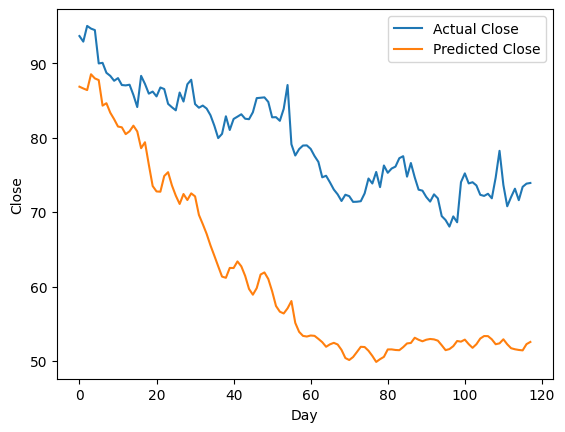

In [ ]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


# RMSE of the Prediction on the Test Set

In [ ]:
import numpy as np
rmse = np.sqrt(np.mean(test_predictions-new_y_test))

print(F'Score (RMSE): {rmse:.4f}')

Score (RMSE): nan


<ipython-input-41-7086b9e931be>:2: RuntimeWarning:

invalid value encountered in sqrt

